In [61]:
# # mounting the drive to access the data

# from google.colab import drive
# drive.mount('/content/drive')

### Problem Statement:- Develope an AI system that can address customer complaints.

In [62]:
# NLP preprocessing libraries
# importing libraries
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.util import ngrams
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from unidecode import unidecode
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
# from autocorrect import Speller

In [63]:
# importing the libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
# Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, SpatialDropout1D, Bidirectional
from sklearn.utils.class_weight import compute_class_weight
# confusion matrix in sklearn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from gensim.models import Word2Vec
# tokenizing the text
from tensorflow.keras.preprocessing.text import Tokenizer

## Data collection

In [ ]:
df = pd.read_csv("/kaggle/input/complaints/complaints.csv")

In [ ]:
df.head()

In [ ]:
df.shape

In [ ]:
df.info()

In [ ]:
df.columns

In [ ]:
df = df[["Product",'Consumer complaint narrative']]
df

To cheack the missing values (NAN)

In [ ]:
df.isna().sum()

In [71]:
df.isna().mean()*100 # around 65% complaints are missing

Product                          0.000000
Consumer complaint narrative    65.208194
dtype: float64

## Potential solutions to deal with missing values
Data augmentation on same target(product) name

generate data using llm's (chatgpt)

dropna


#we chose dropna
even after dropping we'll have 809343 rows, that will be enough

around 65% data is null, if we generate all data model might overfit to generated data

In [72]:
# dropping the values
df.dropna(inplace=True)

In [73]:
df

,Product,Consumer complaint narrative
1,Vehicle loan or lease,I contacted Ally on Friday XX/XX/XXXX after fa...
7,"Credit reporting, credit repair services, or o...",Hello This complaint is against the three cred...
8,"Credit reporting, credit repair services, or o...",I am a victim of Identity Theft & currently ha...
10,"Credit reporting, credit repair services, or o...",Two accounts are still on my credit history af...
13,"Credit reporting, credit repair services, or o...",Receiving daily telephone call ( s ) from XXXX...
...,...,...
2326240,Credit card,"Automated calls from "" XXXX with Capital One '..."
2326241,Debt collection,I have disputed my debts several times with no...
2326242,Mortgage,My father died in XX/XX/XXXX. Left me his only...
2326243,Credit reporting,cfbp i would Like to file a complaint on Exper...


In [74]:
df.shape

(809343, 2)

In [75]:
df.Product.unique() # we are having 18 unique departments

array(['Vehicle loan or lease',
       'Credit reporting, credit repair services, or other personal consumer reports',
       'Credit card or prepaid card',
       'Money transfer, virtual currency, or money service', 'Mortgage',
       'Payday loan, title loan, or personal loan', 'Debt collection',
       'Checking or savings account', 'Student loan', 'Consumer Loan',
       'Money transfers', 'Credit card', 'Bank account or service',
       'Credit reporting', 'Prepaid card', 'Payday loan',
       'Other financial service', 'Virtual currency'], dtype=object)

In [76]:
# df = df.sample(300000).reset_index(drop = True)
# df

In [77]:
df.Product.nunique() # we have 18 unique products.

18

# Merging the Product column data for segregating the data

loan -->'Vehicle loan or lease', 'Student loan'
          'Consumer Loan', 'Payday loan, 'Payday loan, title loan, or personal loan'


credit repot --> 'Credit reporting, credit repair services, or other personal consumer reports','Credit reporting'

card  --->  'Prepaid card',    'Credit card or prepaid card', 'Credit card'

money transfer --> 'Money transfer, virtual currency, or money service',
                    'Money transfers', 'Virtual currency'

account -->  'Checking or savings account', 'Bank account or service'

Mortgage

'Debt collection'

'Other financial service'





In [78]:
# Creating the dictionary for the replacement of the Product column data to assign the key for the respected department.
class_dict =  {
'Vehicle loan or lease' : 'loan',
'Credit reporting, credit repair services, or other personal consumer reports' : 'credit_report',
'Credit card or prepaid card' : 'card' ,
'Money transfer, virtual currency, or money service' : 'money_transfer',
'Mortgage' : 'Mortgage',
'Payday loan, title loan, or personal loan' : 'loan' ,
'Debt collection' : 'Debt collection',
'Checking or savings account' : 'account',
'Student loan' : 'loan',
'Consumer Loan' : 'loan',
'Money transfers' : 'money_transfer',
'Credit card' : 'card',
'Bank account or service' : 'account',
'Credit reporting' : 'credit_report',
'Prepaid card' : 'card',
'Payday loan' : 'loan',
'Other financial service' : 'others',
'Virtual currency' : 'money_transfer'
}

In [79]:
df.replace({'Product' : class_dict}, inplace=True)

In [178]:
df

[['Product', 'clean consumer complaint narrative']]

In [81]:
df.shape

(809343, 2)

In [82]:
df.Product.unique()

array(['loan', 'credit_report', 'card', 'money_transfer', 'Mortgage',
       'Debt collection', 'account', 'others'], dtype=object)

In [83]:
df.Product.nunique() # we have 8 unique departments

8

In [84]:
df.Product.value_counts()

Product
credit_report      348053
Debt collection    157381
Mortgage            84461
card                81042
loan                65744
account             52274
money_transfer      20096
others                292
Name: count, dtype: int64

In [85]:
df.Product.value_counts()/len(df)*100

Product
credit_report      43.004388
Debt collection    19.445526
Mortgage           10.435749
card               10.013307
loan                8.123132
account             6.458819
money_transfer      2.483002
others              0.036079
Name: count, dtype: float64

Dataset is imbalanced
to handle the imbalance following techniques are used

1. SMOTE
2. oversampling, undesmapling

In [86]:
# checking the single complaint for the further operation
df["Consumer complaint narrative"].iloc[200]

'On XX/XX/XXXX, I submitted a query through XXXX XXXX for a cash out refinance. The first lender I spoke to was Supreme Lending who offered one of the lowest rates and also noted I would not need an appraisal, which was part of the reason I chose to work with them. I told the loan officer if they could match the lower rate that came through with another lender I would refinance with Supreme. After a day, he confirmed I would get the lower rate ( though he did not mention I had to buy down to that rate until a later time ). \n\nOn XX/XX/XXXX, the loan officer emailed saying we didnt get approval not to do an appraisal. This was the first time it was mentioned no appraisal would require an approval. In that email, he also told me we would get the fee waived and if not hed make up for it. I paid {$720.00} for an appraisal that took place on XX/XX/XXXX. \n\nOn XX/XX/XXXX, the loan officer told me to make up for the issues with no waiver my first payment would be pushed to XXXX instead of X

for the complaints we need to do text cleaning to make the reviews into standard format

form the above complaints text we need to do following text cleaning
1. lower the text
2. punctuation remove
3. xxx
4. digits removal
5. new line chars (\n)


In [87]:
import re

In [88]:
def clean_text(text):
  """this function is used to clean the text"""
  # lowering the text
  text = text.lower()

  # removing punc and digits
  text = re.sub(r'[^a-z\s]',"",text)

  #removing more than one occurance of XX
  text = re.sub('[x]{2,}',"",text)

  #remove stopwords

  #remove more than one occurence of space

  return text



In [89]:
# preprocessing
# 1. remove spaces,newlines
def remove_spaces(data):
    clean_text = data.replace('\\n',' ').replace("\t",' ').replace('\\',' ')
    return clean_text

# 2. contraction mapping
def expand_text(data):
    expanded_text = contractions.fix(data)
    return expanded_text

# 3.handling accented character
def handling_accented(data):
    fixed_text = unidecode(data)
    return fixed_text

# 4. Cleaning
stopword_list = stopwords.words("english")
# stopword_list.remove('no')
# stopword_list.remove('nor')
# stopword_list.remove('not')

def clean_data(data):
    tokens = word_tokenize(data)
    clean_text = [word.lower() for word in tokens if word.lower() not in stopword_list and(len(word)>2) and (word.isalpha())]
    return clean_text                   # and(word.lower() not in stopword_list) and(len(word)>2) and (word.isalpha())]

# 5.autocorrect
def autocorrection(data):
    spell = Speller(lang='en')
    corrected_text = spell(data)

# 6. lemmatization
def lemmatization(data):
    lemmatizer = WordNetLemmatizer()
    final_data = []
    for word in data :
        lemmatized_word = lemmatizer.lemmatize(word)
        final_data.append(lemmatized_word)
    return " ".join(final_data)

In [90]:
import time
start_time = time.time()
clean_text_train =df['Consumer complaint narrative'].apply(clean_text)

clean_text_train = clean_text_train.apply(remove_spaces)

# clean_text_train = clean_text_train.apply(expand_text)

clean_text_train = clean_text_train.apply(handling_accented)

clean_text_train = clean_text_train.apply(clean_data)

#clean_text_train = clean_text_train.apply(lemmatization)

# clean_text_train = clean_text_train.apply(autocorrection)

end_time = time.time()
total_time_taken = (end_time-start_time)
print("total_time_taken",total_time_taken)

total_time_taken 897.9023041725159


In [91]:
clean_text_train = clean_text_train.apply(lambda x : ' '.join(x))
clean_text_train

1          contacted ally friday falling behind payments ...
7          hello complaint three credit reporting compani...
8          victim identity theft currently experian accou...
10         two accounts still credit history contacting c...
13         receiving daily telephone call identifying att...
                                 ...                        
2326240    automated calls capital one calls home phone e...
2326241    disputed debts several times resolution submit...
2326242    father died left son belongings also single mo...
2326243    cfbp would like file complaint experian report...
2326244    husband middle fha short sale property located...
Name: Consumer complaint narrative, Length: 809343, dtype: object

In [92]:
df['clean consumer complaint narrative'] = clean_text_train

In [93]:
df

,Product,Consumer complaint narrative,clean consumer complaint narrative
1,loan,I contacted Ally on Friday XX/XX/XXXX after fa...,contacted ally friday falling behind payments ...
7,credit_report,Hello This complaint is against the three cred...,hello complaint three credit reporting compani...
8,credit_report,I am a victim of Identity Theft & currently ha...,victim identity theft currently experian accou...
10,credit_report,Two accounts are still on my credit history af...,two accounts still credit history contacting c...
13,credit_report,Receiving daily telephone call ( s ) from XXXX...,receiving daily telephone call identifying att...
...,...,...,...
2326240,card,"Automated calls from "" XXXX with Capital One '...",automated calls capital one calls home phone e...
2326241,Debt collection,I have disputed my debts several times with no...,disputed debts several times resolution submit...
2326242,Mortgage,My father died in XX/XX/XXXX. Left me his only...,father died left son belongings also single mo...
2326243,credit_report,cfbp i would Like to file a complaint on Exper...,cfbp would like file complaint experian report...


In [94]:
df['Consumer complaint narrative'].iloc[200]

'On XX/XX/XXXX, I submitted a query through XXXX XXXX for a cash out refinance. The first lender I spoke to was Supreme Lending who offered one of the lowest rates and also noted I would not need an appraisal, which was part of the reason I chose to work with them. I told the loan officer if they could match the lower rate that came through with another lender I would refinance with Supreme. After a day, he confirmed I would get the lower rate ( though he did not mention I had to buy down to that rate until a later time ). \n\nOn XX/XX/XXXX, the loan officer emailed saying we didnt get approval not to do an appraisal. This was the first time it was mentioned no appraisal would require an approval. In that email, he also told me we would get the fee waived and if not hed make up for it. I paid {$720.00} for an appraisal that took place on XX/XX/XXXX. \n\nOn XX/XX/XXXX, the loan officer told me to make up for the issues with no waiver my first payment would be pushed to XXXX instead of X

In [95]:
df['clean consumer complaint narrative'].iloc[200]

'submitted query cash refinance first lender spoke supreme lending offered one lowest rates also noted would need appraisal part reason chose work told loan officer could match lower rate came another lender would refinance supreme day confirmed would get lower rate though mention buy rate later time loan officer emailed saying didnt get approval appraisal first time mentioned appraisal would require approval email also told would get fee waived hed make paid appraisal took place loan officer told make issues waiver first payment would pushed instead explained would happen via refund check payment old mortgage closed assured morning prior signing receive refund check covering first full payment long due date check emailed asking loan status refund check since received notice supreme already sold mortgage called stated needed wait full weeks funding passed would still check emailed told office looking next day returned called say escalating would update next day emailed asking update si

In [96]:
# checking length of each complaint
length = []
for i in df['clean consumer complaint narrative']:
  length.append(len(i))

In [97]:
# checking avg lengh of complaint
sum(length)/len(length)

613.0834751150007

In [98]:
# maximum length of the complaint is 971.0605533333334 (words)

In [99]:
# tokenizing the text
from tensorflow.keras.preprocessing.text import Tokenizer
tokenier = Tokenizer(num_words=15000,lower=True) #num_words this is vocab size

In [100]:
tokenier.fit_on_texts(df['clean consumer complaint narrative'])

In [101]:
word_index = tokenier.word_index

In [102]:
word_index["check"]

59

In [103]:
# cross checking the word form their index
value_to_find = 137
for key,value in word_index.items():
  if value == value_to_find:
    print(key)

notice


In [104]:
#vectorization : converting text to numbers
X = tokenier.texts_to_sequences(df['clean consumer complaint narrative'].values)
print(X[0])

[53, 1027, 1047, 2811, 643, 21, 26, 166, 615, 385, 15, 26, 3813, 156, 3229, 2, 154, 816, 972, 1, 1007, 2, 214, 235, 42, 182, 55, 5, 36, 656, 2114, 2602, 2123, 434, 33, 5, 975, 394, 235, 5, 5045, 2, 81, 1027, 23, 10384, 5, 13675, 313, 7, 1184, 53, 1027, 187, 4899, 315, 4, 97, 4899, 394, 98, 369, 48, 86, 570, 235, 30, 114, 63, 5, 42, 182, 112, 1124, 5, 238, 235, 6, 26, 141, 25, 2143, 249, 840, 2958, 6, 26, 21, 236, 63, 6, 3292, 155, 527, 33, 5, 42, 2123, 434, 13, 436, 73, 3065, 47, 85, 1268, 26, 530, 293, 455, 7, 13, 13, 231, 456, 91, 7515, 71, 884, 16, 943, 10623, 666, 71, 264, 26, 1643, 10623, 230, 113, 166]


In [105]:
len(X[0])

131

In [106]:
df["Product"]

1                     loan
7            credit_report
8            credit_report
10           credit_report
13           credit_report
                ...       
2326240               card
2326241    Debt collection
2326242           Mortgage
2326243      credit_report
2326244      credit_report
Name: Product, Length: 809343, dtype: object

In [107]:
# target column
Y = pd.get_dummies(df["Product"]).values
Y

array([[False, False, False, ...,  True, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False,  True, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [108]:
len(Y[0])

8

In [109]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [110]:
x = pad_sequences(X,maxlen=800)
x[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [111]:
len(x[1])

800

In [112]:
len(x)

809343

In [113]:
# spliting the data into trainning and testing

x_train, x_test, y_train, y_test = train_test_split(x,Y,test_size=0.2,random_state=9,stratify=Y) # more data is used for training

In [114]:
x_train.shape

(647474, 800)

In [115]:
x_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [116]:
y_train.shape

(647474, 8)

In [117]:
y_train[0]

array([False, False, False, False,  True, False, False, False])

In [118]:
#Model
model=Sequential()
model.add(Embedding(10000,100)) #10000 is the vocab size (input_dim), and 100 is output_dim
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(8, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [119]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [120]:
# assigning weight to the calss lables
# we are assigning the weight to handle the imbalance in the data.

class_labels = np.unique(df['Product'])

from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight ='balanced',classes=np.unique(df['Product']),y = df['Product'])

# class_weights.sort()
class_weights_dict = dict(zip(class_labels, class_weights))

In [121]:
class_weights_dict

{'Debt collection': 0.6428214015668982,
 'Mortgage': 1.1978057920223535,
 'account': 1.9353383135019322,
 'card': 1.248338824313319,
 'credit_report': 0.2906680160780111,
 'loan': 1.5388153291555122,
 'money_transfer': 5.034229448646497,
 'others': 346.46532534246575}

In [122]:
df['Product'].value_counts()

Product
credit_report      348053
Debt collection    157381
Mortgage            84461
card                81042
loan                65744
account             52274
money_transfer      20096
others                292
Name: count, dtype: int64

In [123]:
# ! pip install --upgrade jax jaxlib

In [124]:
import time
from memory_profiler import profile

@profile
def train_model():
    start_time = time.time()
    history = model.fit(x_train,
                        y_train,
                        epochs=7,
                        batch_size=2064,
                        validation_split=0.1,
                        class_weight=class_weights_dict,
                        callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
    end_time = time.time()
    total_time_taken = (end_time - start_time)
    print("total_time_taken", total_time_taken)
    return history

history = train_model()


ERROR: Could not find file /tmp/ipykernel_33/995348491.py
Epoch 1/7
283/283 ━━━━━━━━━━━━━━━━━━━━ 3776s 13s/step - accuracy: 0.5782 - loss: 1.2109 - val_accuracy: 0.8087 - val_loss: 0.5880
Epoch 2/7
283/283 ━━━━━━━━━━━━━━━━━━━━ 3781s 13s/step - accuracy: 0.7969 - loss: 0.6200 - val_accuracy: 0.8291 - val_loss: 0.5229
Epoch 3/7
283/283 ━━━━━━━━━━━━━━━━━━━━ 3756s 13s/step - accuracy: 0.8213 - loss: 0.5472 - val_accuracy: 0.8437 - val_loss: 0.4794
Epoch 4/7
283/283 ━━━━━━━━━━━━━━━━━━━━ 3751s 13s/step - accuracy: 0.8370 - loss: 0.4972 - val_accuracy: 0.8464 - val_loss: 0.4613
Epoch 5/7
283/283 ━━━━━━━━━━━━━━━━━━━━ 3792s 13s/step - accuracy: 0.8443 - loss: 0.4715 - val_accuracy: 0.8495 - val_loss: 0.4482
Epoch 6/7
283/283 ━━━━━━━━━━━━━━━━━━━━ 3801s 13s/step - accuracy: 0.8496 - loss: 0.4505 - val_accuracy: 0.8528 - val_loss: 0.4340
Epoch 7/7
283/283 ━━━━━━━━━━━━━━━━━━━━ 3859s 14s/step - accuracy: 0.8540 - loss: 0.4349 - val_accuracy: 0.8542 - val_loss: 0.4264
total_time_taken 26521.204754829

In [125]:
# import time
# start_time = time.time()
# history = model.fit(x_train,
#                     y_train,
#                     epochs=7,
#                     batch_size=2064,
#                     validation_split=0.1,
#                     class_weight=class_weights_dict,
#                     callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
# end_time = time.time()
# total_time_taken = (end_time-start_time)
# print("total_time_taken",total_time_taken)
# # print(history)

In [ ]:
print("total_time_taken in hr's:-- ",total_time_taken/3600)

In [127]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 800, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 800, 100)       │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           808 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,243,626 (12.37 MB)

 Trainable params: 1,081,208 (4.12 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,162,418 (8.25 MB)

In [128]:
accr = model.evaluate(x_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

5059/5059 ━━━━━━━━━━━━━━━━━━━━ 728s 144ms/step - accuracy: 0.8552 - loss: 0.4268
Test set
  Loss: 0.425
  Accuracy: 0.855


In [129]:
pred = model.predict(x_test)

5059/5059 ━━━━━━━━━━━━━━━━━━━━ 742s 147ms/step


In [130]:
y_pred=np.argmax(pred, axis=1)
y_test_=np.argmax(y_test, axis=1)

In [131]:
# confusion matrix
matrix = confusion_matrix(y_test_,y_pred)

Text(0.5, 1.0, 'Confusion Matrix')

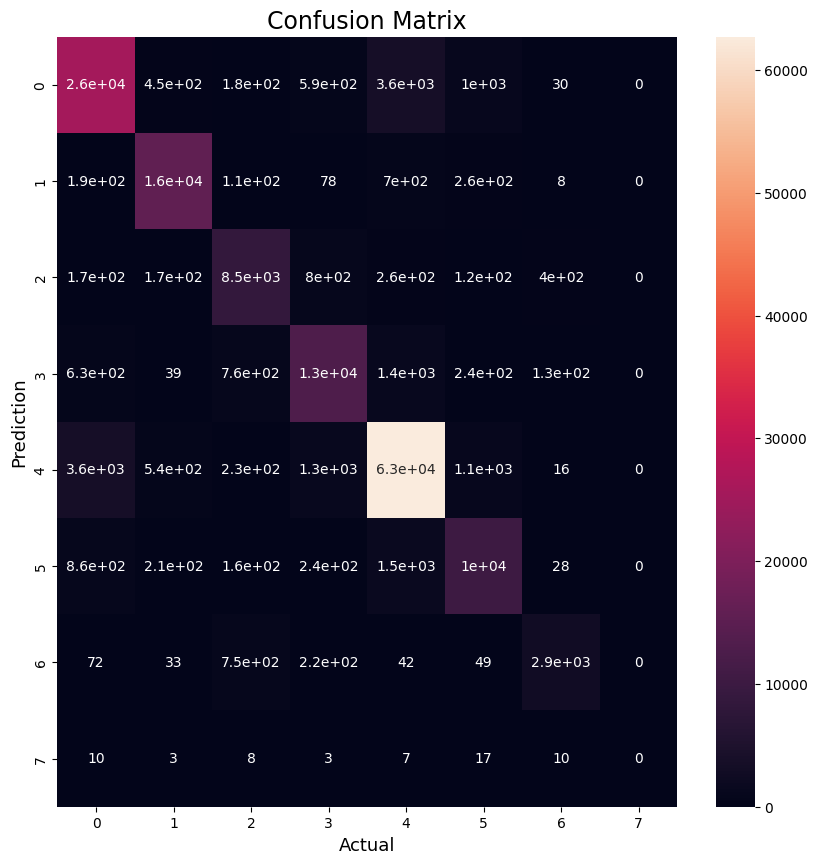

In [132]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(matrix,
            annot=True,)
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)

In [133]:
print(classification_report(y_test_, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.81      0.82     31476
           1       0.91      0.92      0.92     16892
           2       0.80      0.82      0.81     10455
           3       0.80      0.80      0.80     16209
           4       0.89      0.90      0.90     69611
           5       0.78      0.77      0.78     13149
           6       0.82      0.71      0.76      4019
           7       0.00      0.00      0.00        58

    accuracy                           0.86    161869
   macro avg       0.73      0.72      0.72    161869
weighted avg       0.85      0.86      0.85    161869



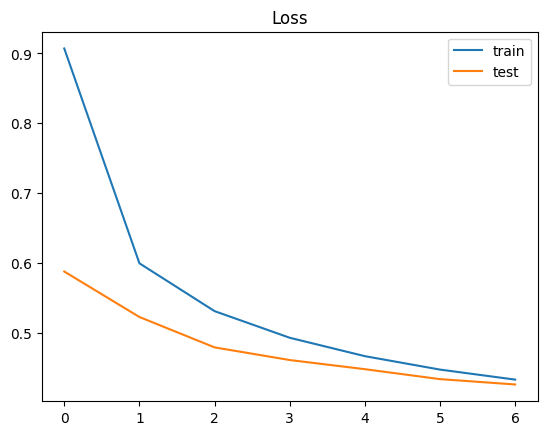

In [134]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

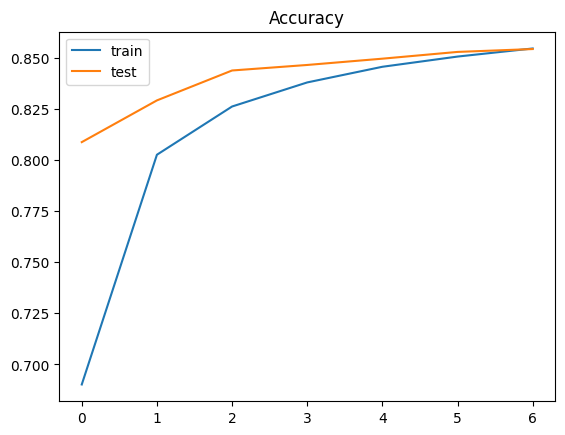

In [135]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()

In [136]:
# tokenizing the text
from tensorflow.keras.preprocessing.text import Tokenizer
tokenier = Tokenizer(num_words=10000,lower=True) #num_words this is vocab size

In [154]:
new_complaint = ['''i contacted ally on friday after falling behind on payments due to being out of work for a short period of time due to an illness i chated with a representative after logging into my account regarding my opitions to ensure i protect my credit and bring my account current

she advised me that before an extenstion could be done i had to make a payment in the amount of i reviewed my finances as i am playing catch up on all my bills and made this payment on monday this rep advised me once this payment posts to my account to contact ally back for an extention or to have a payment deffered to the end of my loan

with this in mind i contacted ally again today and chatted with i explained all of the above and the information i was provided when i chatted with the rep last week she asked several questions and advised me that a one or two month extension deffered payment could be done however partial payment is needed what she advised me or there abouts would be due within days from me accepting the agreement and then the remaining bal of or there abouts would be due in in my payments of per month would resume

if this was the case i should have just been offered this when i just made my payment so that i could catch up on my bills

this company was working with in new jersey which has since closed most likely due to illegal practices they changed my loan company to this company after i had signed paperwork for another kill you with interest rates and has never once considered refiancing my vechile for a lower interest rate due to the age of the vechile other companies will not take it and they do not work with you ''']

In [157]:
seq = tokenier.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=1000)
pred = model.predict(padded)
labels = ['credit_report','debt_collection','mortgage','card','loan','account','money_transfer','others']
print(pred, labels[np.argmax(pred)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
[[0.15685885 0.08134505 0.08135772 0.08111724 0.28154698 0.09482386
  0.07237279 0.15057753]] loan


In [138]:
# import pickle
# filename = '/kaggle/working/finalized_model.h5'
# pickle.dump(model, open(filename, 'wb'))

In [139]:
import os
os.chdir(r'/kaggle/working')

In [147]:
model.save('/kaggle/working/finalized_model.h5')

In [141]:
import pickle

with open("/kaggle/working/tokenizer.pickle", 'wb') as file:
  pickle.dump(tokenier, file)

In [142]:
import os
os.getcwd()

'/kaggle/working'

In [148]:
os.listdir()

['tokenizer.pickle', 'finalized_model.h5', '.virtual_documents', 'models']

In [144]:
import pickle
with open("/kaggle/working/tokenizer.pickle", 'rb') as f:
  tokenizer = pickle.load(f)